In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import os
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

Toy model of decomposition of index returns into returns of underlying sectors.

Start with the sector returns generated from a multivariate normal and combined with
a weight vector

In [3]:
n_sector = 8
n_days = 100

In [4]:
with pm.Model() as generating_model:
    sector_weights = pm.Dirichlet('sector weights', a=np.ones(n_sector))
    sd_dist = pm.Exponential.dist(1.0, shape=(n_sector, ))

    chol, corr, sigmas = pm.LKJCholeskyCov(
        'chol_cov', eta=4, n=n_sector, sd_dist=sd_dist,
    )

    sector_returns = pm.MvNormal(
        'sector_returns', mu=0., chol=chol,
        size=n_days,
    )

    index_returns = pm.Normal(
        'index_returns',
        mu=sector_returns @ sector_weights,
        sigma=0.2,
    )

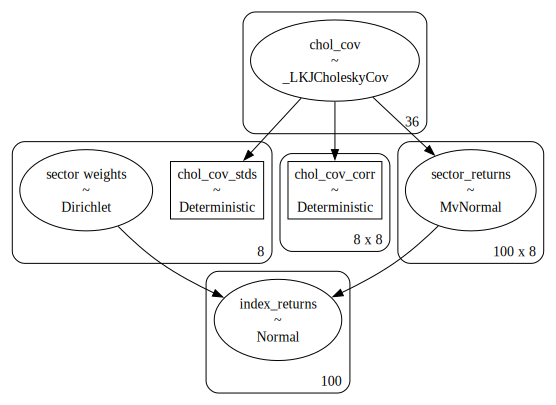

In [5]:
pm.model_to_graphviz(generating_model)

Generate samples, each draw returns the actual sector weight,
n_days of sector returns and the overall index returns calculated from the sector
returns and the sector weights plus some noise

In [7]:
w, c, rho, s, X, y = pm.draw([sector_weights, chol, corr, sigmas, sector_returns, index_returns], 1)

Text(0.5, 1.0, 'Sector returns')

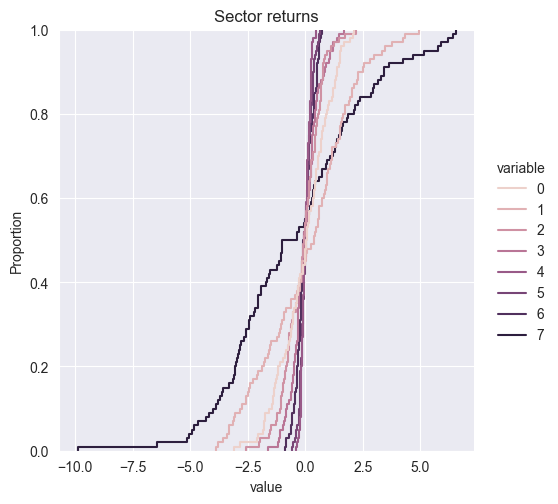

In [8]:
g = sns.displot(pd.DataFrame(X).melt(), x='value', hue='variable', kind='ecdf')
plt.title('Sector returns')

Text(0.5, 1.0, 'Index returns')

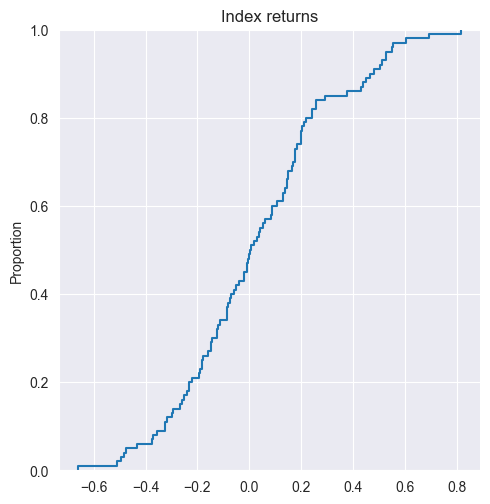

In [9]:
g = sns.displot(y, kind='ecdf')
plt.title('Index returns')

Text(0.5, 1.0, 'Index Returns vs Weighted Sector returns')

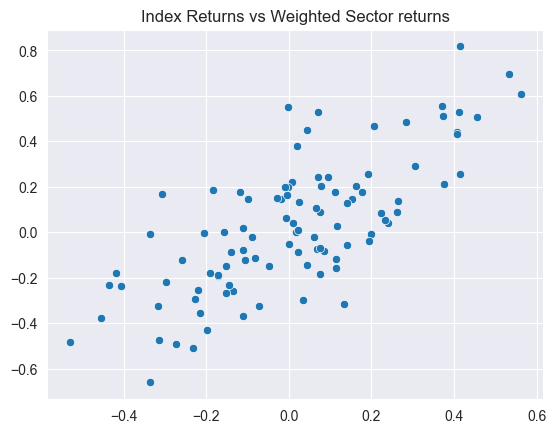

In [28]:
sns.scatterplot(x=X @ w, y=y)
plt.title('Index Returns vs Weighted Sector returns')

Find the sector weights by fitting a Dirichlet distribution to the sector and index returns.

In [11]:
with pm.Model() as fit_model:
    fit_weights = pm.Dirichlet('fit weights', a=np.ones(n_sector))
    obs = pm.Normal('returns', mu=X @ fit_weights, sigma=0.2, observed=y)

In [12]:
with fit_model:
    idata = pm.sample(1000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, show_progress=False)

/Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.10 is maybe too old for this OS.
  warnings.warn(


Running window adaptation


/Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1101: UserWarning: Some donated buffers were not usable: ShapedArray(float64[16,1000,7]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'fit weights'}>,
        <Axes: title={'center': 'fit weights'}>]], dtype=object)

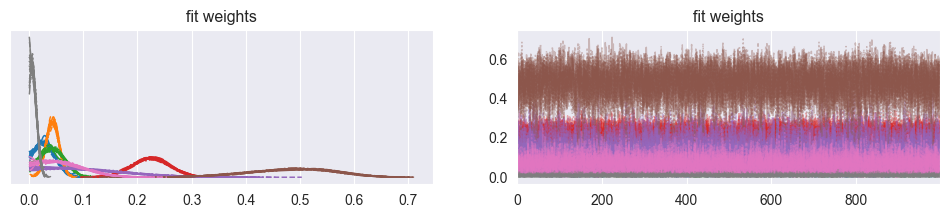

In [13]:
az.plot_trace(idata)

<Axes: >

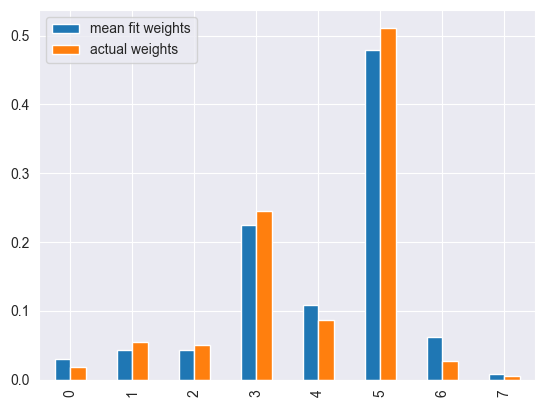

In [27]:
pd.DataFrame(
    {
        'mean fit weights': idata.posterior['fit weights'].mean(axis=1).mean(axis=0),
        'actual weights': w
    }
).plot(kind='bar')